# `mle-launcher`: Lightweight Cluster/Cloud Job Scheduling 🚂
### Author: [@RobertTLange](https://twitter.com/RobertTLange) [Last Update: November 2021][![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/mle-launcher/blob/main/examples/getting_started.ipynb)

In [15]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

try:
    import mle_launcher
except:
    !pip install -q mle-launcher
    import mle_launcher

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


```python
def main(experiment_dir: str, config_fname: str, seed_id: int):
    """Example training 'loop' using MLE-Logging."""
    train_config = load_yaml_config(config_fname)
    log = MLELogger(
        experiment_dir=experiment_dir,
        config_fname=config_fname,
        seed_id=seed_id,
        time_to_track=["num_epochs"],
        what_to_track=["train_loss", "test_loss"],
    )
    for epoch in range(1, 11):
        train_loss, test_loss = train_your_net(epoch, seed_id, **train_config)
        log.update(
            {"num_epochs": epoch},
            {"train_loss": train_loss, "test_loss": test_loss},
            save=True,
        )
```

# Single Job Management with `MLEJob` 🚀

In [16]:
import logging
from mle_launcher import MLEJob

# Launch a python train_mnist.py -config base_config.json job
job = MLEJob(resource_to_run="local",
             job_filename="train.py",
             config_filename="base_config_1.yaml",
             experiment_dir="logs_single",
             job_arguments={"env_name": "mle-toolbox"},
             use_conda_virtual_env=True,
             logger_level=logging.INFO)

job.run()

INFO:root:PID: 20251 - Local job scheduled - base_config_1.yaml
INFO:root:PID: 20251 - Local job successfully completed - base_config_1.yaml


0

# Job Queue Management with `MLEQueue` 🚀🚀🚀

In [17]:
from mle_launcher import MLEQueue

# Launch a queue of 4 jobs (2 configs x 2 seeds)
# python train_mnist.py -config base_config_1.json -seed 0
# python train_mnist.py -config base_config_1.json -seed 1
# python train_mnist.py -config base_config_2.json -seed 0
# python train_mnist.py -config base_config_2.json -seed 1
queue = MLEQueue(resource_to_run="local",
                 job_filename="train.py",
                 config_filenames=["base_config_1.yaml",
                                   "base_config_2.yaml"],
                 num_seeds=2,
                 random_seeds=[0, 1],
                 experiment_dir="logs_queue",
                 job_arguments={"env_name": "mle-toolbox"},
                 use_conda_virtual_env=True,
                 automerge_seeds=True,
                 logger_level=logging.INFO)
queue.run()

INFO:mle_launcher.job_queue:QUEUED - 2 random seeds - 2 configs
INFO:mle_launcher.job_queue:TOTAL JOBS TO EXECUTE - 4
INFO:mle_launcher.job_queue:LAUNCH - FIRST 4/4 SET OF JOBS
100%|█████████████████████████████████████████████| 4/4 [00:02<00:00,  1.53it/s]     


# Log Post-Processing with `mle-logging`

(<Figure size 648x432 with 1 Axes>,
 <AxesSubplot:title={'center':'train_loss, test_loss'}, xlabel='num_epochs', ylabel='train_loss, test_loss'>)

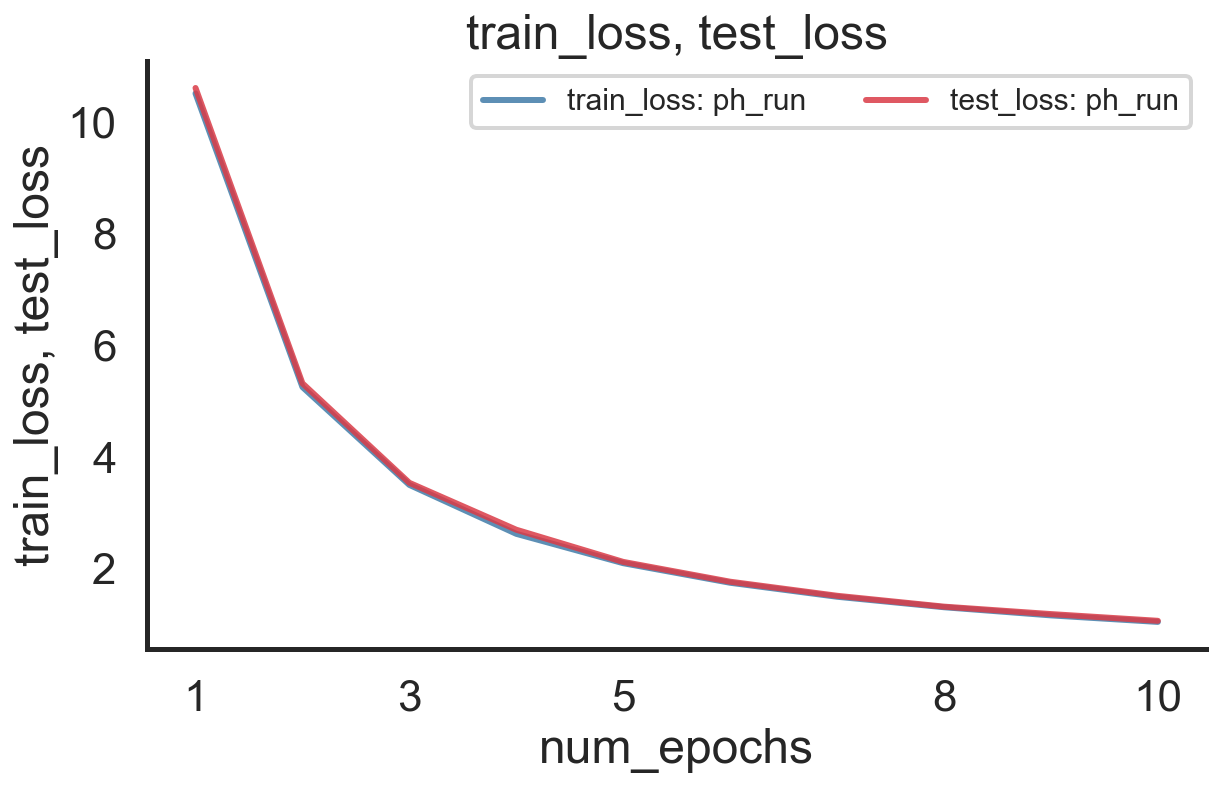

In [18]:
from mle_logging import load_log

log = load_log("logs_single/21-11-07_base_config_1")
log.plot(["train_loss", "test_loss"])

# Job Launching with `mle-hyperopt` Configurations

In [19]:
try:
    import mle_hyperopt
except:
    !pip install -q mle-hyperopt
    import mle_hyperopt

In [20]:
from mle_hyperopt import RandomSearch

# Instantiate random search class
strategy = RandomSearch(real={"lrate": {"begin": 0.1,
                                        "end": 0.5,
                                        "prior": "log-uniform"}},
                        integer={"batch_size": {"begin": 1,
                                                "end": 5,
                                                "prior": "uniform"}},
                        categorical={"arch": ["mlp", "cnn"]})

# Simple ask - eval - tell API
configs, config_fnames = strategy.ask(2, store=True)

In [21]:
queue = MLEQueue(resource_to_run="local",
                 job_filename="train.py",
                 config_filenames=config_fnames,
                 num_seeds=1,
                 experiment_dir="logs_queue",
                 job_arguments={"env_name": "mle-toolbox"},
                 use_conda_virtual_env=True,
                 automerge_seeds=True,
                 logger_level=logging.INFO)
queue.run()

INFO:mle_launcher.job_queue:QUEUED - 1 random seeds - 2 configs
INFO:mle_launcher.job_queue:TOTAL JOBS TO EXECUTE - 2
INFO:mle_launcher.job_queue:LAUNCH - FIRST 2/2 SET OF JOBS
100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]     
